In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from copy import deepcopy
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
TRAIN_FILE = 'train-balanced-sarcasm.csv'

In [3]:
train_df = pd.read_csv(TRAIN_FILE)
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
train_df.shape

(1010826, 10)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [6]:
train_df.dropna(subset=['comment'], inplace=True)

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [8]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'].values, train_df['label'].values, random_state=17)

In [9]:
def preprocessing(texts):
    return [re.sub(r"([^ \w])", r" \1 ", str.lower(text)) for text in texts]

def tokenization(texts):
    return [text.split() for text in texts]

def build_vocabulary(data):
    vocab = dict()
    for d in data:
        for w in d:
            try:
                vocab[w]
            except:
                vocab[w] = len(vocab)
    return vocab

def build_w2v_dict_nn(file_path, vocab, d=300):
    emb_dict = dict()
    unk_array = np.zeros(d)
    w2v_model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    for word in vocab.keys():
        try:
            vector = w2v_model.get_vector(word)
            emb_dict[word] = vector
            unk_array += vector
        except:
            continue
    emb_dict['UNK'] = unk_array / len(emb_dict)
    emb_dict['PAD'] = np.zeros(d)
    return emb_dict

def build_emb_matrix_nn_w2v(file_path, vocab, d=300):
    emb_dict = build_w2v_dict_nn(file_path, vocab, d=d)
    emb_matrix = np.zeros((len(emb_dict), d))
    word2idx = {'UNK': 0, 'PAD': 1}
    for word in sorted(list(set(emb_dict.keys()) - set(['UNK', 'PAD']))):
        word2idx[word] = len(word2idx)
    for w, i in word2idx.items():
        emb_matrix[i] = emb_dict[w]
    emb_matrix = torch.tensor(emb_matrix)
    return emb_matrix, word2idx

class BiLSTM(nn.Module):
    def __init__(self, emb_matrix, hidden_size=64, output_size=2, freeze_emb=True):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(emb_matrix)
        if freeze_emb:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=self.embedding.embedding_dim,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x_emb = self.embedding(x)
        # (batch, seq_len, num_directions * hidden_size)
        lstm_out, _ = self.lstm(x_emb.float())
        # (batch, seq_len, num_directions, hidden_size)
        lstm_out = lstm_out.view(lstm_out.shape[0], lstm_out.shape[1], -1, self.hidden_size)
        # lstm_out[:, :, 0, :] -- output of the forward LSTM
        # lstm_out[:, :, 1, :] -- output of the backward LSTM
        # we take the last hidden state of the forward LSTM and the first hidden state of the backward LSTM
        x_fc = torch.cat((lstm_out[:, -1, 0, :], lstm_out[:, 0, 1, :]), dim=1)
        fc_out = self.fc(x_fc)
        out = self.softmax(fc_out)
        return out

def as_matrix(documents, word2idx, max_len=None):
    max_doc_len = max(map(len, documents))
    if max_len is None:
        max_len = max_doc_len
    else:
        max_len = min(max_doc_len, max_len)
    matrix = np.ones((len(documents), max_len), dtype=np.int64)
    for i, doc in enumerate(documents):
        row_ix = [word2idx.get(word, 0) for word in doc[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    return matrix

def train_bilstm(model, optimizer, train_data, train_labels_tensor, dev_data, dev_labels_tensor, word2idx, max_len=300, device=device, n_epochs=50, batch_size=128):
    model.to(device)

    train_loss_curve = [np.nan] * n_epochs
    val_loss_curve = [np.nan] * n_epochs
    train_accuracy_curve = [np.nan] * n_epochs
    val_accuracy_curve = [np.nan] * n_epochs
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0
    best_state_dict = None

    train_size = len(train_data)
    val_size = len(dev_data)

    n_batches_train = (train_size - 1) // batch_size + 1
    n_batches_val = (val_size - 1) // batch_size + 1

    for epoch in range(n_epochs):
        model.train()

        train_loss_curve[epoch] = 0
        train_accuracy_curve[epoch] = 0
        
        for i in tqdm(range(0, train_size, batch_size)):
            x = as_matrix(train_data[i:(i + batch_size)], word2idx, max_len)
            x = torch.tensor(x).long()
            y = train_labels_tensor[i:(i + batch_size)].float()
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            
            labels_pred = prediction.argmax(dim=-1, keepdim=False).view(-1)
            labels_true = y.argmax(dim=-1, keepdim=False).view(-1)
            train_accuracy_curve[epoch] += labels_pred.eq(labels_true).sum().item() / len(y)

            loss = nn.BCELoss()(prediction, y)
            train_loss_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        train_accuracy_curve[epoch] /= n_batches_train

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 5))

        train_loss_curve[epoch] /= n_batches_train
        axes[0].plot(train_loss_curve, label='train')

        model.eval()

        val_loss_curve[epoch] = 0
        val_accuracy_curve[epoch] = 0
        with torch.no_grad():
            for i in tqdm(range(0, val_size, batch_size)):
                x = as_matrix(dev_data[i:(i + batch_size)], word2idx, max_len)
                x = torch.tensor(x).long()
                y = dev_labels_tensor[i:(i + batch_size)].float()
                x = x.to(device)
                y = y.to(device)
                prediction = model(x)
                
                labels_pred = prediction.argmax(dim=-1, keepdim=False).view(-1)
                labels_true = y.argmax(dim=-1, keepdim=False).view(-1)
                val_accuracy_curve[epoch] += labels_pred.eq(labels_true).sum().item() / len(y)

                loss = nn.BCELoss()(prediction, y)
                val_loss_curve[epoch] += loss.item()
        
        val_accuracy_curve[epoch] /= n_batches_val
        val_loss_curve[epoch] /= n_batches_val
        axes[0].plot(val_loss_curve, label='val')
        axes[0].set_title('Loss: train {:.4f}, val {:.4f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        axes[0].legend()
        axes[0].set_xlabel('epochs')
        axes[0].set_ylabel('loss')
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            best_state_dict = deepcopy(model.state_dict())
        
        axes[1].set_title('Accuracy: train {:.4f}, val {:.4f} (best: {:.4f}, epoch {})'.format(
            train_accuracy_curve[epoch],
            val_accuracy,
            max_val_accuracy,
            max_val_accuracy_epoch
        ))
        axes[1].plot(train_accuracy_curve, label='train')
        axes[1].plot(val_accuracy_curve, label='val')
        axes[1].legend()
        axes[1].set_xlabel('epochs')
        axes[1].set_ylabel('accuracy')

        plt.tight_layout()
        plt.show()
    return best_state_dict

def set_random_seeds(seed_value=13, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [10]:
%%time

train_tokens = tokenization(preprocessing(train_texts))
valid_tokens = tokenization(preprocessing(valid_texts))

vocab = build_vocabulary(train_tokens)
print("Vocabulary size:", len(vocab))

emb_matrix, word2idx = build_emb_matrix_nn_w2v('googlenews/GoogleNews-vectors-negative300.bin', vocab)
print('Unique vectors in embedding matrix:', len(emb_matrix))

train_labels_tensor = torch.tensor(y_train)
train_labels_tensor = torch.cat([1 - train_labels_tensor.view(-1, 1), train_labels_tensor.view(-1, 1)], dim=1)
dev_labels_tensor = torch.tensor(y_valid)
dev_labels_tensor = torch.cat([1 - dev_labels_tensor.view(-1, 1), dev_labels_tensor.view(-1, 1)], dim=1)

Vocabulary size: 143374
Unique vectors in embedding matrix: 62374
Wall time: 1min 14s


100%|█████████████████████████████████████████████████████████████████████████████| 1975/1975 [00:16<00:00, 123.38it/s]


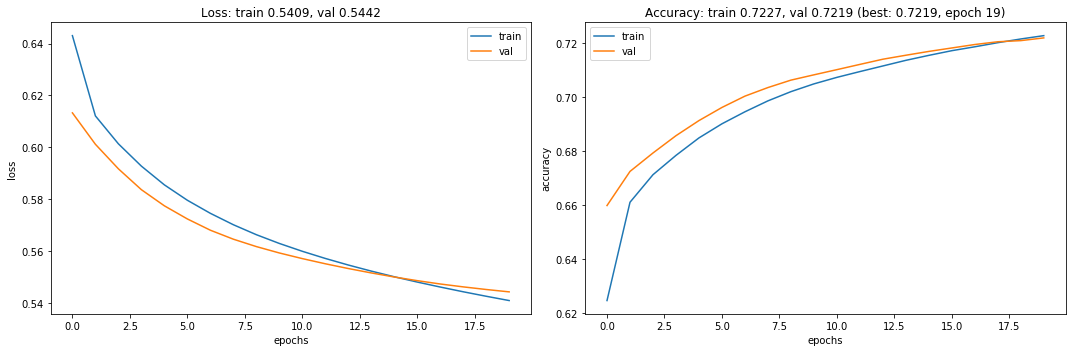

Wall time: 47min 30s


In [11]:
%%time

hidden_size = 128
lr = 0.1

bilstm = BiLSTM(emb_matrix, hidden_size)
optimizer = optim.SGD(bilstm.parameters(), lr=lr)

set_random_seeds(13, device)
bilstm_glove_state_dict = train_bilstm(bilstm, optimizer, train_tokens, train_labels_tensor, valid_tokens, dev_labels_tensor, word2idx, n_epochs=20)

In [13]:
STATE_DICT_PATH = 'bilstm_w2v.pt'
torch.save(bilstm_glove_state_dict, STATE_DICT_PATH)